# DefaultUnuranSamplingStrategy Sampling Examples


This notebook mirrors `example_sampling_strategy_custom_distribution.py` and demonstrates four sampling tasks:

1. Sampling from an exponential PDF using AUTO mode.

2. Sampling via an exponential CDF with method NINV.

3. Discrete PMF sampling with method DGT.

4. Overriding methods (AUTO vs PINV) for a normal distribution.


## Imports and CustomDistribution implementation


In [19]:
from __future__ import annotations

import math
from collections.abc import Iterable, Mapping
from dataclasses import dataclass
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from pysatl_core.distributions import (
    AnalyticalComputation,
    DefaultComputationStrategy,
)
from pysatl_core.distributions.distribution import Distribution
from pysatl_core.stats._unuran.api import UnuranMethod, UnuranMethodConfig
from pysatl_core.stats._unuran.bindings._core import DefaultUnuranSamplingStrategy
from pysatl_core.types import CharacteristicName, EuclideanDistributionType, Kind


@dataclass(slots=True)
class CustomDistribution(Distribution):
    """Minimal univariate distribution wired to DefaultUnuranSamplingStrategy."""

    name: str
    kind: Kind
    parameters: dict[str, Any]
    _analytical: dict[str, AnalyticalComputation[Any, Any]]
    _sampling_strategy: DefaultUnuranSamplingStrategy
    _distribution_type: EuclideanDistributionType
    _computation_strategy: DefaultComputationStrategy

    def __init__(
        self,
        name: str,
        kind: Kind,
        analytical_computations: Iterable[AnalyticalComputation[Any, Any]]
        | Mapping[str, AnalyticalComputation[Any, Any]],
        sampling_strategy: DefaultUnuranSamplingStrategy,
        *,
        parameters: Mapping[str, Any] | None = None,
    ) -> None:
        self.name = name
        self.kind = kind
        self.parameters = dict(parameters or {})
        self._distribution_type = EuclideanDistributionType(kind=kind, dimension=1)
        if isinstance(analytical_computations, Mapping):
            self._analytical = dict(analytical_computations)
        else:
            self._analytical = {ac.target: ac for ac in analytical_computations}
        self._sampling_strategy = sampling_strategy
        self._computation_strategy = DefaultComputationStrategy()

    @property
    def distribution_type(self) -> EuclideanDistributionType:
        return self._distribution_type

    @property
    def analytical_computations(self) -> Mapping[str, AnalyticalComputation[Any, Any]]:
        return self._analytical

    @property
    def sampling_strategy(self) -> DefaultUnuranSamplingStrategy:
        return self._sampling_strategy

    def set_sampling_strategy(self, sampling_strategy: DefaultUnuranSamplingStrategy) -> None:
        self._sampling_strategy = sampling_strategy

    @property
    def computation_strategy(self) -> DefaultComputationStrategy:
        return self._computation_strategy

    @property
    def support(self) -> None:
        return None

## Plotting helpers


In [20]:
PLOTS_DIR = Path("__file__").parent / "plots"
PLOTS_DIR.mkdir(exist_ok=True)


def _save_and_display(fig: plt.Figure, filename: str) -> None:
    plots_dir = Path.cwd() / "plots"
    plots_dir.mkdir(parents=True, exist_ok=True)

    path = plots_dir / filename
    fig.savefig(path, dpi=200, bbox_inches="tight")
    display(fig)
    print(f"  ➜ Figure saved to {path.relative_to(Path.cwd())}")


def _close(fig: plt.Figure) -> None:
    plt.close(fig)


def _plot_continuous_pdf(
    title: str, xs: np.ndarray, pdf_vals: np.ndarray, samples: np.ndarray, filename: str
) -> None:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(title)
    ax.plot(xs, pdf_vals, label="Ideal PDF", color="tab:red")
    ax.hist(samples, bins=80, density=True, alpha=0.5, label="Sampled", color="tab:blue")
    ax.set_xlabel("x")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True, alpha=0.3)
    _save_and_display(fig, filename)
    _close(fig)


def _plot_normal_override(
    title: str,
    xs: np.ndarray,
    pdf_vals: np.ndarray,
    data_auto: np.ndarray,
    data_pinv: np.ndarray,
    filename: str,
) -> None:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(title)
    ax.plot(xs, pdf_vals, label="Ideal PDF", color="tab:red")
    ax.hist(
        data_auto,
        bins=60,
        density=True,
        alpha=0.55,
        label="AUTO",
        color="#1f77b4",
    )
    ax.hist(
        data_pinv,
        bins=60,
        density=True,
        alpha=0.45,
        label="PINV",
        color="#ff7f0e",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True, alpha=0.3)
    _save_and_display(fig, filename)
    _close(fig)


def _plot_continuous_cdf(
    title: str, xs: np.ndarray, cdf_vals: np.ndarray, samples: np.ndarray, filename: str
) -> None:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(title)
    ax.plot(xs, cdf_vals, label="Ideal CDF", color="tab:red")
    sorted_samples = np.sort(samples)
    ecdf = np.arange(1, len(sorted_samples) + 1) / len(sorted_samples)
    ax.plot(sorted_samples, ecdf, label="Empirical CDF", color="tab:blue", linestyle="--")
    ax.set_xlabel("x")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.grid(True, alpha=0.3)
    _save_and_display(fig, filename)
    _close(fig)


def _plot_discrete_pmf(
    title: str, pmf: dict[int, float], samples: np.ndarray, filename: str
) -> None:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(title)
    xs = np.array(sorted(pmf.keys()))
    probs = np.array([pmf[int(x)] for x in xs])
    ax.bar(xs - 0.15, probs, width=0.3, label="Ideal PMF", color="tab:red", alpha=0.8)

    unique, counts = np.unique(samples.astype(int), return_counts=True)
    freq = counts / counts.sum()
    ax.bar(unique + 0.15, freq, width=0.3, label="Sampled PMF", color="tab:blue", alpha=0.6)

    ax.set_xlabel("value")
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True, axis="y", alpha=0.3)
    _save_and_display(fig, filename)
    _close(fig)

### Example 1 – Exponential PDF (AUTO)
Goal: demonstrate sampling from a continuous distribution via an analytical PDF using AUTO method.


=== Example 1: Continuous PDF (AUTO) ===
Mean ≈ 0.5026 (expected 0.5000)
Std  ≈ 0.4987 (expected 0.5000)


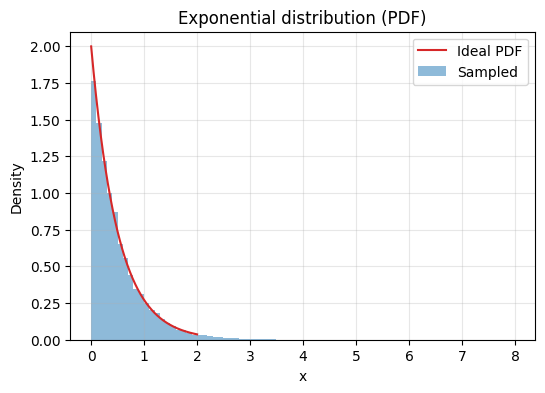

  ➜ Figure saved to plots/exp_pdf.png


In [21]:
def example_exponential_pdf() -> None:
    print("=== Example 1: Continuous PDF (AUTO) ===")
    lam = 2.0

    def pdf_func(x: float, **_: Any) -> float:
        return lam * math.exp(-lam * x) if x >= 0 else 0.0

    distr = CustomDistribution(
        name="Exp(λ=2)",
        kind=Kind.CONTINUOUS,
        analytical_computations=[
            AnalyticalComputation(target=CharacteristicName.PDF, func=pdf_func),
        ],
        sampling_strategy=DefaultUnuranSamplingStrategy(),
    )

    data = distr.sample(30_000).array.flatten()
    print(f"Mean ≈ {data.mean():.4f} (expected {1/lam:.4f})")
    print(f"Std  ≈ {data.std():.4f} (expected {1/lam:.4f})")

    xs = np.linspace(0, 4 / lam, 400)
    pdf_vals = np.array([pdf_func(x) for x in xs])
    _plot_continuous_pdf("Exponential distribution (PDF)", xs, pdf_vals, data, "exp_pdf.png")


example_exponential_pdf()

### Example 2 – Exponential CDF with NINV
Goal: show how DefaultUnuranSamplingStrategy can work from an analytical CDF using method NINV.


=== Example 2: CDF sampling with NINV ===
Mean ≈ 0.6630 (expected 0.6667)
Std  ≈ 0.6647 (expected 0.6667)


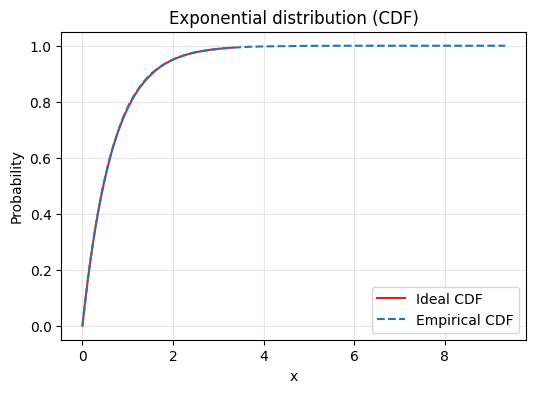

  ➜ Figure saved to plots/exp_cdf.png


In [22]:
def example_exponential_cdf() -> None:
    print("=== Example 2: CDF sampling with NINV ===")
    lam = 1.5

    def cdf_func(x: float, **_: Any) -> float:
        return 0.0 if x < 0 else 1.0 - math.exp(-lam * x)

    distr = CustomDistribution(
        name="Exp CDF(λ=1.5)",
        kind=Kind.CONTINUOUS,
        analytical_computations=[
            AnalyticalComputation(target=CharacteristicName.CDF, func=cdf_func),
        ],
        sampling_strategy=DefaultUnuranSamplingStrategy(
            default_config=UnuranMethodConfig(method=UnuranMethod.NINV, use_cdf=True)
        ),
    )

    data = distr.sample(40_000).array.flatten()
    print(f"Mean ≈ {data.mean():.4f} (expected {1/lam:.4f})")
    print(f"Std  ≈ {data.std():.4f} (expected {1/lam:.4f})")

    xs = np.linspace(0, 5 / lam, 400)
    cdf_vals = np.array([cdf_func(x) for x in xs])
    _plot_continuous_cdf("Exponential distribution (CDF)", xs, cdf_vals, data, "exp_cdf.png")


example_exponential_cdf()

### Example 3 – Discrete PMF with DGT
Goal: demonstrate sampling of a discrete PMF using method DGT without relying on registry characteristics..



=== Example 3: Discrete distribution (DGT) ===
Goal: demonstrate sampling of a discrete PMF using method DGT without relying on registry characteristics.
Observed frequencies:
  value 0 → 0.200 (expected: 0.2)
  value 1 → 0.496 (expected: 0.5)
  value 2 → 0.303 (expected: 0.3)


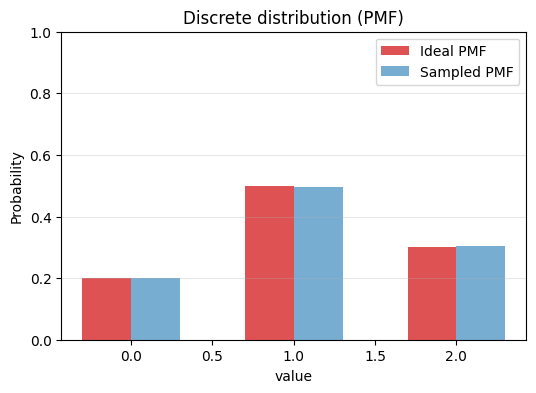

  ➜ Figure saved to plots/discrete_pmf.png


In [ ]:
def example_discrete_pmf() -> None:
    print("\n=== Example 3: Discrete distribution (DGT) ===")
    print(
        "Goal: demonstrate sampling of a discrete PMF using method DGT without"
        " relying on registry characteristics."
    )
    pmf = {0: 0.2, 1: 0.5, 2: 0.3}

    distr = CustomDistribution(
        name="Discrete weighted",
        kind=Kind.DISCRETE,
        analytical_computations={
            CharacteristicName.PMF: AnalyticalComputation(
                target=CharacteristicName.PMF,
                func=lambda x, **_: pmf.get(int(x), 0.0),
            )
        },
        sampling_strategy=DefaultUnuranSamplingStrategy(
            default_config=UnuranMethodConfig(
                method=UnuranMethod.DGT,
                use_registry_characteristics=False,
            )
        ),
        parameters={"pmf": pmf},
    )

    data = distr.sample(20_000).array.flatten()
    unique, counts = np.unique(data, return_counts=True)
    print("Observed frequencies:")
    for value, freq in zip(unique, counts / counts.sum(), strict=False):
        print(f"  value {int(value)} → {freq:.3f} (expected: {pmf[int(value)]})")

    _plot_discrete_pmf("Discrete distribution (PMF)", pmf, data, "discrete_pmf.png")


example_discrete_pmf()

### Example 4 – AUTO vs PINV override
Goal: compare AUTO vs an explicit PINV override on the same Gaussian distribution.



=== Example 4: Overriding the method per sample() call ===
Goal: compare AUTO vs an explicit PINV override on the same Gaussian distribution.
Expected mean ≈ 0.000, std ≈ 1.000 for both methods.
AUTO: mean=0.018, std=0.999
PINV: mean=-0.014, std=1.003


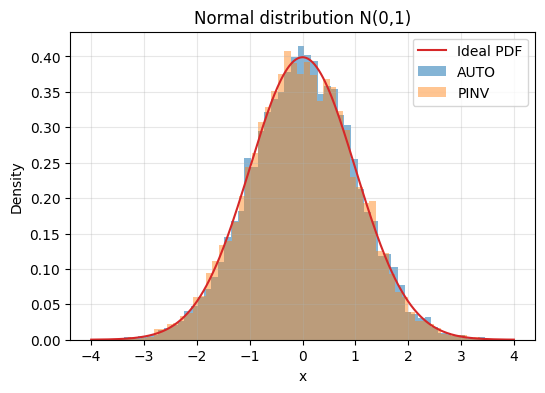

  ➜ Figure saved to plots/normal_override.png


In [24]:
def example_override_method() -> None:
    print("\n=== Example 4: Overriding the method per sample() call ===")
    print("Goal: compare AUTO vs an explicit PINV override on the same Gaussian distribution.")
    print("Expected mean ≈ 0.000, std ≈ 1.000 for both methods.")

    def pdf_func(x: float, **_: Any) -> float:
        return (1.0 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x * x)

    strategy = DefaultUnuranSamplingStrategy()
    distr = CustomDistribution(
        name="Normal N(0,1)",
        kind=Kind.CONTINUOUS,
        analytical_computations=[
            AnalyticalComputation(target=CharacteristicName.PDF, func=pdf_func),
        ],
        sampling_strategy=strategy,
    )

    data_auto = distr.sample(10_000).array.flatten()
    data_pinv = distr.sample(10_000, method=UnuranMethod.PINV).array.flatten()
    print(f"AUTO: mean={data_auto.mean():.3f}, std={data_auto.std():.3f}")
    print(f"PINV: mean={data_pinv.mean():.3f}, std={data_pinv.std():.3f}")

    xs = np.linspace(-4, 4, 400)
    pdf_vals = np.array([pdf_func(x) for x in xs])
    _plot_normal_override(
        "Normal distribution N(0,1)",
        xs,
        pdf_vals,
        data_auto,
        data_pinv,
        "normal_override.png",
    )


example_override_method()